# **Laboratorio 4 - Informe**
### Grupo 4:
     - S. Calvo C.I 5.711.417-7     
     - X. Iribarnegaray C.I 5.253.705-9
     - J. Simonelli C.I 5.405.358-4

## **1. Inicializaciones**

#### **1.1 Bibliotecas**

In [78]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from IPython.display import display, HTML, Image # pip install jinja2 , necesario para mostrar tablas con styles

#### **1.2 Preprocesamiento**

En el siguiente bloque dividimos el dataset en conjuntos de train y test (80/20), y el conjunto de train lo dividimos en conjunto de entrenamiento y validación (90/10). Además, removemos los atributos *pidnum* y *time*, este último por consigna.

In [79]:
data = pd.read_csv('dataset.csv')

def init(data):
    data = data.drop(columns=['pidnum','time'])
    train, test = train_test_split(data, test_size=0.2, random_state=0)
    train_90, val = train_test_split(train, test_size=0.1, random_state=0)
    return train, train_90, val, test

target = 'cid'

train, train_90, val, test = init(data)


In [80]:
X_final_train, y_final_train = train.drop(columns=[target]), train[target]
X_train, y_train = train_90.drop(columns=[target]), train_90[target]
X_val, y_val = val.drop(columns=[target]), val[target]
X_test, y_test = test.drop(columns=[target]), test[target]

En el dataset original, múltiples atributos se encuentran en diferentes escalas. Por ejemplo, el atributo *age* se encuentra en un rango de 0 a 100, mientras que el atributo *cd820*  llega a tomar valores por encima de 1000. Esto puede provocar que la red le atribuya "mayor importancia" a ciertos atributos de mayor valor, lo que no representa la realidad. Por esto, es necesario estandarizar los atributos continuos, o sea, transformar los valores de entrada con tal de obtener una varianza de 1 y media de 0. Para ello, utilizamos la clase StandardScaler de la librería scikit-learn sobre todos los atributos continuos `continuous_features`. Además, aplicamos One-hot Encoding sobre los atributos categóricos de más de dos valores, que en este caso es solamente *trt*, para que la red pueda interpretarlos correctamente.

El preprocesamiento de los datos fue realizado después de la división en conjuntos de entrenamiento y prueba para evitar la fuga de información. Al realizar la estandarización y la codificación solo en los datos de entrenamiento, nos aseguramos de que ninguna información del conjunto de prueba influya en el proceso de entrenamiento. Posteriormente, aplicamos las mismas transformaciones al conjunto de prueba utilizando los parámetros obtenidos del conjunto de entrenamiento.

In [81]:
discrete_features = ['trt']
continuous_features = [
    'age', 
    'wtkg', 
    'preanti', 
    'cd40', 
    'cd420', 
    'cd80', 
    'cd820',
    'karnof'
]

# Crear un ColumnTransformer con OneHotEncoder para características discretas y StandardScaler para características continuas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), discrete_features)
    ],
    remainder='passthrough'  # Mantener otras columnas tal como están (si las hay)
)

# Ajustar el preprocesador en el conjunto de entrenamiento y aplicarlo a otros conjuntos
# Usar fit_transform en X_train y transform en los otros para evitar fuga de datos
X_train = pd.DataFrame(preprocessor.fit_transform(X_train), columns=preprocessor.get_feature_names_out(), index=X_train.index)
X_val = pd.DataFrame(preprocessor.transform(X_val), columns=preprocessor.get_feature_names_out(), index=X_val.index)
X_final_train = pd.DataFrame(preprocessor.transform(X_final_train), columns=preprocessor.get_feature_names_out(), index=X_final_train.index)
X_test = pd.DataFrame(preprocessor.transform(X_test), columns=preprocessor.get_feature_names_out(), index=X_test.index)

# Definir el tamaño de entrada para los modelos que lo necesiten
input_size = X_train.shape[1]


## **2. Modelos**

### **Modelo 1**

La implementación de un modelo de regresión logística en este caso utiliza la biblioteca scikit-learn para construir un clasificador base a partir de los datos de entrenamiento.

Comenzamos instanciando el modelo con `LogisticRegression()` y entrenándolo en el conjunto de entrenamiento mediante `fit`. Luego, el modelo genera predicciones en el conjunto de validación con el método `predict`. Para evaluar su rendimiento, se calcula la tasa de aciertos (accuracy), que mide el total de aciertos sobre la cantidad total de predicciones.

In [82]:
def train_logistic_regression(X_train, y_train, X_val, y_val):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    
    return model, accuracy

model1, accuracy_val = train_logistic_regression(X_train, y_train, X_val, y_val)

print(f"Accuracy del Modelo 1 en el conjunto de validación: {accuracy_val:.4f}")


Accuracy del Modelo 1 en el conjunto de validación: 0.8198


Previo a detallar la implementación de las redes neuronales solicitadas, implementaremos la función de entrenamiento que utilizaremos en todos los modelos restantes del informe. Esta función recibe como parámetros el modelo, el conjunto de entrenamiento, el conjunto de validación, la cantidad de épocas, la tasa de aprendizaje `lr`, la función de pérdida, y el número del modelo. La función entrena el modelo y devuelve el acierto y pérdida por época para el conjunto de entrenamiento y validación.

In [83]:
def train_model(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, epochs=100, lr=0.01, criterion='CrossEntropyLoss', modelNumber=2):
    # Función de pérdida
    if (criterion == 'CrossEntropyLoss'):
        loss_fn = torch.nn.CrossEntropyLoss()
    elif (criterion == 'BCELoss'): 
        loss_fn = torch.nn.BCELoss()
    
    # Optimizador
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_loss, val_loss = [], []
    train_accuracy, val_accuracy = [], []
    
    for epoch in range(epochs):
        model.train()

        # Paso hacia adelante (forward)
        y_train_pred = model(X_train_tensor)
        loss = loss_fn(y_train_pred, y_train_tensor)
        
        # Paso hacia atrás (backward)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Métricas de entrenamiento
        if (modelNumber == 2):
            predicted = torch.argmax(y_train_pred, dim=1)
        else:
            predicted = y_train_pred.round()
            
        train_acc = (predicted == y_train_tensor).float().mean().item()
        
        train_loss.append(loss.item())
        train_accuracy.append(train_acc)
        
        # Métricas de validación
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            if (modelNumber == 2):
                val_predicted = torch.argmax(val_outputs, dim=1)
            else:
                val_predicted = (val_outputs).round()
            val_acc = (val_predicted == y_val_tensor).float().mean().item()
        
        # Almacenar métricas
        val_loss.append(loss_fn(val_outputs, y_val_tensor).item())
        val_accuracy.append(val_acc)
    
    return train_loss, val_loss, train_accuracy, val_accuracy

epochs = 100
learning_rate = 0.01


La función inicia definiendo la función de pérdida en función del tipo de criterio especificado. Si el criterio es *CrossEntropyLoss*, se utiliza para tareas de clasificación multiclase, mientras que *BCELoss* se emplea para clasificación binaria.

Luego, se establece el optimizador, en este caso Adam, con la tasa de aprendizaje especificada. A continuación, la función entra en un bucle de entrenamiento que itera durante el número de épocas indicadas. En cada época, el modelo pasa a modo de entrenamiento mediante `model.train()`, lo cual habilita la función de Dropout, que será usada en las arquitecturas propuestas para el Modelo 5. Se realiza una pasada hacia adelante sobre los datos de entrenamiento `X_train_tensor`, obteniendo las predicciones `y_train_pred` del modelo. La pérdida se calcula comparando las predicciones con las etiquetas verdaderas en `y_train_tensor` usando la función de pérdida previamente definida.

Para actualizar los parámetros, primero reiniciamos los gradientes mediante `optimizer.zero_grad()`, luego se realiza la pasada hacia atrás utilizando `loss.backward()`, y finalmente se actualizan los parámetros del modelo mediante `optimizer.step()`. La tasa de aciertos del entrenamiento se calcula de acuerdo al criterio de pérdida: en el caso de *BCELoss*, se redondean las predicciones para obtener valores binarios (0 o 1); en el caso de *CrossEntropyLoss*, se utiliza `argmax` para seleccionar la clase con la probabilidad más alta. Estas predicciones se comparan con las etiquetas verdaderas para obtener la precisión, que junto a la pérdida de entrenamiento, se almacena para la época actual.

Posteriormente, el modelo se pone en modo de evaluación con `model.eval()` y se calculan las métricas de validación sin realizar ajustes en los parámetros. Las predicciones sobre el conjunto de validación `X_val_tensor` se procesan de manera similar a lo descrito anteriormente, y la tasa de aciertos de validación se calcula y almacena junto con la pérdida en el conjunto de validación. 

Finalmente, la función retorna las pérdidas y tasas de aciertos de entrenamiento y validación para cada época, lo que permite observar la evolución del rendimiento del modelo a lo largo del entrenamiento.

Con respecto a los gráficos, implementamos la función `plot_metrics` para que, a partir de los resultados obtenidos en el entrenamiento y validación, se grafiquen las pérdidas y tasas de acierto en función de las épocas.

In [84]:
epochs_list = range(0, epochs)

def plot_metrics(modelName, train_loss, val_loss, train_accuracy, val_accuracy):
    plt.figure(figsize=(12, 5))
    
    # Gráfico de pérdida
    plt.subplot(1, 2, 1)
    plt.plot(epochs_list, train_loss, label='P. entrenamiento')
    plt.plot(epochs_list, val_loss, label='P. validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    loss_title = modelName + ' - Pérdida en entrenamiento y validación'
    plt.title(loss_title)
    plt.legend()

    # Gráfico de aciertos
    plt.subplot(1, 2, 2)
    plt.plot(epochs_list, train_accuracy, label='A. entrenamiento')
    plt.plot(epochs_list, val_accuracy, label='A. validación')
    plt.xlabel('Épocas')
    plt.ylabel('Aciertos')
    acc_title = modelName + ' - Aciertos en entrenamiento y validación'
    plt.title(acc_title)
    plt.legend()
    
    plt.tight_layout()
    plt.show()


### **Modelo 2**

El segundo modelo a implementar es ahora una red neuronal, de una sola neurona lineal, con dos salidas, una para cada clase objetivo del conjunto de datos.

In [85]:
class SimpleLinearNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleLinearNN, self).__init__()
        self.linear = nn.Linear(input_size, 2)

    def forward(self, x):
        return self.linear(x)
    
    def predict(self, x):
        self.eval()
        
        with torch.no_grad():
            logits = self.forward(x)
            _, predicted_classes = torch.max(logits, 1)
        
        return predicted_classes


Los datos de entrada `X_train` y `X_val` se convierten en tensores de tipo FloatTensor, mientras que las etiquetas `y_train` e `y_val` se transforman en LongTensor para que sean compatibles con la función de pérdida de entropía cruzada *CrossEntropyLoss*.

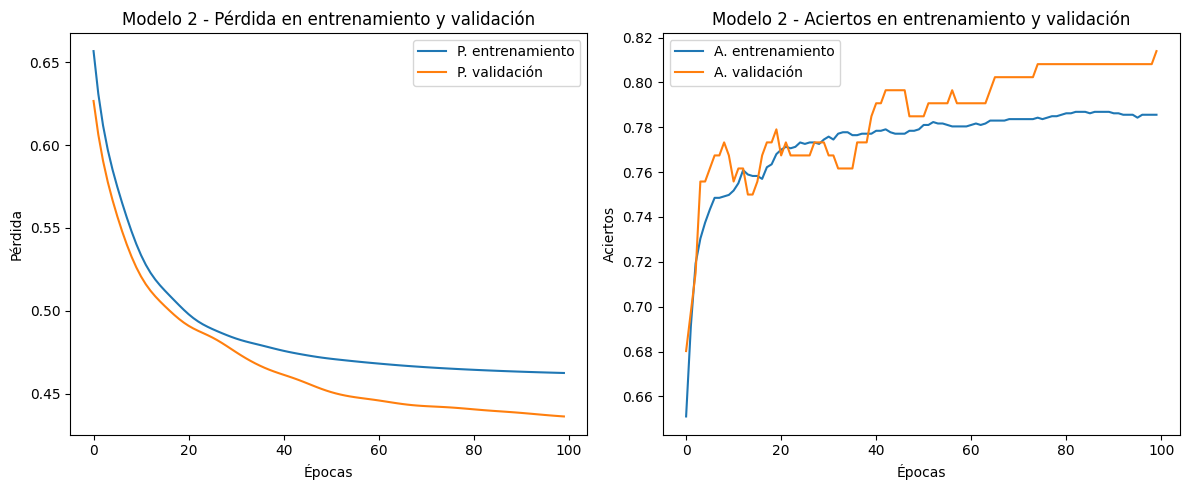

In [86]:
model2 = SimpleLinearNN(input_size)

X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.LongTensor(y_train.values)
X_val_tensor = torch.FloatTensor(X_val.values)
y_val_tensor = torch.LongTensor(y_val.values)

train_loss, val_loss, train_accuracy, val_accuracy = train_model(
    model2,
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    epochs,
    learning_rate,
    criterion='CrossEntropyLoss',
    modelNumber=2
)

plot_metrics('Modelo 2',train_loss, val_loss, train_accuracy, val_accuracy)

**Gráfica de pérdida**

En la gráfica de la pérdida, se observa una disminución rápida tanto en el conjunto de entrenamiento como en el de validación durante las primeras 20 épocas. Esta tendencia indica que el modelo está aprendiendo a clasificar los datos y que la pérdida general está disminuyendo a medida que se ajustan los pesos del modelo. Posteriormente, la pérdida se estabiliza en un valor bajo, lo cual sugiere que el modelo ha alcanzado un estado de convergencia.

**Gráfica de aciertos**

En la gráfica de aciertos, se observa un aumento rápido de los aciertos tanto en el conjunto de entrenamiento como en el de validación durante las primeras épocas. El acierto en el conjunto de validación muestra un comportamiento similar al del entrenamiento, llegando a estabilizarse alrededor del 80%, lo que indica que el modelo ha logrado una clasificación razonablemente acertada. 

El desempeño del modelo muestra una mejor tasa de aciertos y menor pérdida en el conjunto de validación que en el conjunto de entrenamiento, lo que sugiere que no está logrando capturar funciones lo suficientemente complejas como para sobreajustarse al conjunto de entrenamiento. Esto podría deberse a la capacidad limitada del modelo o un tiempo de entrenamiento insuficiente (pocas épocas). Para abordar esta situación, es recomiendable aumentar la complejidad del modelo o el número de épocas, buscando un equilibrio adecuado entre generalización y sobreajuste.

### **Modelo 3**

El siguiente modelo que construimos es una red neuronal compuesta por una única neurona, cuya salida está determinada por la función sigmoide. 

Al igual que en otros modelos, antes de poder entrenar esta red neuronal, es necesario convertir los conjuntos de entrenamiento y validación en tensores. En el caso de los tensores correspondientes a las salidas, se debe añadir una dimensión adicional utilizando la función `unsqueeze()`. Esta operación es esencial debido a que, al emplear *BCELoss* como función de pérdida durante el entrenamiento, los tensores de valor verdadero y de predicción deben tener dimensiones compatibles. Dado que nuestro modelo produce un único valor por cada caso, la salida resultante es un tensor de forma [N, 1], donde N representa el número de casos. Al aplicar la función `unsqueeze()`, garantizamos que tanto `y_train_tensor` como `y_val_tensor` tengan las mismas dimensiones que la salida del modelo.

Al realizar predicciones, los valores de la salida se redondean a las clases del problema, dada la naturaleza booleana de la tarea.

In [87]:
class SigmoidNN(nn.Module):
    def __init__(self, input_size):
        super(SigmoidNN, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))
    
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            probabilities = self.forward(x)
            predictions = probabilities.round()
        return predictions


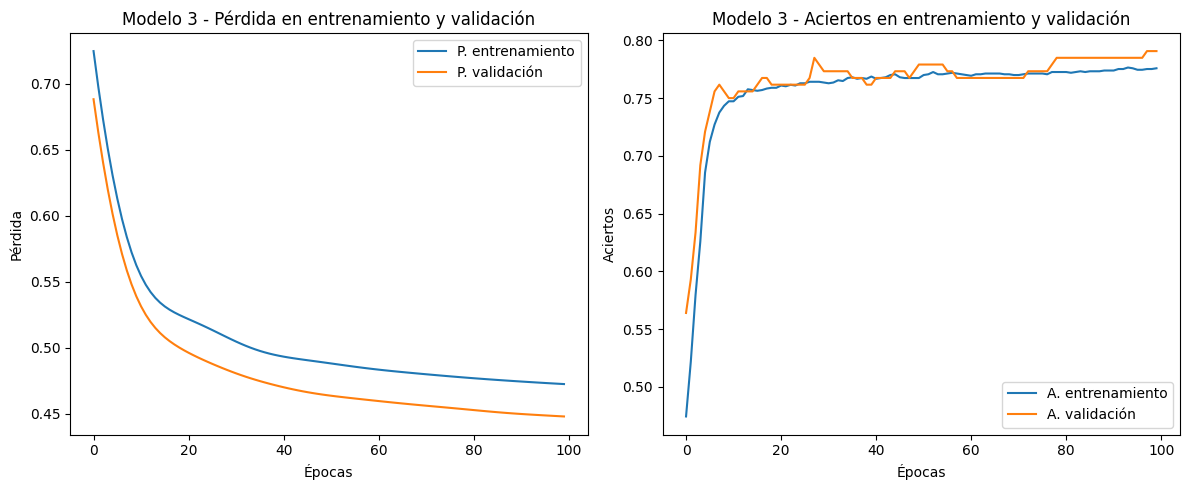

In [88]:
model3 = SigmoidNN(input_size)
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1)
X_val_tensor = torch.FloatTensor(X_val.values)
y_val_tensor = torch.FloatTensor(y_val.values).unsqueeze(1)

train_loss, val_loss, train_accuracy, val_accuracy = train_model(
    model3,
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    epochs,
    learning_rate,
    criterion='BCELoss',
    modelNumber=3
)

plot_metrics('Modelo 3', train_loss, val_loss, train_accuracy, val_accuracy)

Dada las gráficas de pérdida y aciertos, podemos notar que el modelo está aprendiendo exitosamente, con un gran aprendizaje al comienzo seguido de pocas correcciones debido a la baja pérdida. 

### **Modelo 4**

La última red neuronal es una red neuronal feedforward con una capa oculta con 16 neuronas y una sola salida. Para esta salida utilizamos la función sigmoide como función de activación. Durante el entrenamiento, al igual que el modelo anterior, utilizamos el criterio *BCELoss* por lo cual utilizamos los mismos tensores.

In [89]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size):
        super(FeedForwardNN, self).__init__()
        self.hidden = nn.Linear(input_size, 16)
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.sigmoid(self.hidden(x))
        return torch.sigmoid(self.output(x))
    
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            probabilities = self.forward(x)
            predictions = probabilities.round()
        return predictions
    

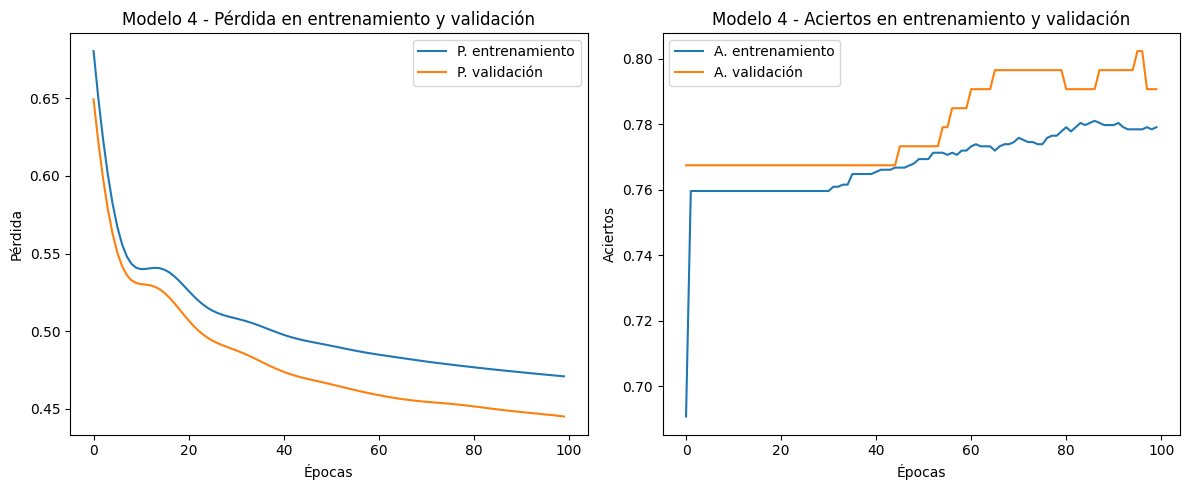

In [90]:
model4 = FeedForwardNN(input_size)
train_loss, val_loss, train_accuracy, val_accuracy = train_model(
    model4,
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    epochs,
    learning_rate,
    criterion='BCELoss',
    modelNumber=4
)

plot_metrics('Modelo 4',train_loss, val_loss, train_accuracy, val_accuracy)

Como es de esperarse, la pérdida tiende a bajar mientras que el acierto tiende a subir.

**Obs:** En este modelo de mayor complejidad, al incrementar el número de épocas, observamos un comportamiento de sobreajuste. Aunque el modelo continuó mejorando en términos de pérdida y precisión sobre el conjunto de entrenamiento, el rendimiento en el conjunto de validación se estabilizó y comenzó a mostrar indicios de degradación. Lo que indica que el modelo es suficientemente complejo para capturar patrones específicos del conjunto de entrenamiento (que no se generalizan bien a datos nuevos).

![title](resources/modelo4_300.png)

### **Modelo 5**

A continuación proponemos 3 arquitecturas posibles.

In [91]:
class ModelA(nn.Module):
    def __init__(self, input_size):
        super(ModelA, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.output = nn.Linear(16, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.output(x))
    
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            probabilities = self.forward(x)
            predictions = probabilities.round()
        return predictions

class ModelB(nn.Module):
    def __init__(self, input_size):
        super(ModelB, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.4)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        return torch.sigmoid(self.output(x))
    
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            probabilities = self.forward(x)
            predictions = probabilities.round()
        return predictions

class ModelC(nn.Module):
    def __init__(self, input_size):
        super(ModelC, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.output = nn.Linear(8, 1)
        self.dropout = nn.Dropout(0.4)
        
    def forward(self, x):
        x = torch.nn.functional.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = self.dropout(x)
        x = torch.nn.functional.leaky_relu(self.fc2(x), negative_slope=0.01)
        x = self.dropout(x)
        x = torch.nn.functional.leaky_relu(self.fc3(x), negative_slope=0.01)
        return torch.sigmoid(self.output(x))
    
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            probabilities = self.forward(x)
            predictions = probabilities.round()
        return predictions


**Modelo A**

El Modelo A tiene la misma arquitectura que el Modelo 4, pero cambia la función de activación en la capa oculta de sigmoide a ReLU. La función ReLU, definida como $f(x)=max(0,x)$, convierte los valores negativos en cero y mantiene los positivos sin cambios. Esto facilita un aprendizaje más eficiente, ya que la red ajusta los pesos para capturar relaciones importantes en las activaciones positivas.

**Model B**

En el Modelo B introdujimos dos capas ocultas con 32 y 16 neuronas respectivamente, ambas con función de activación ReLU, y añadimos un dropout de 0.4. Comparado con el Modelo A, el aumento en la cantidad de neuronas y capas permite al modelo capturar patrones más complejos, mientras que el dropout ayuda a reducir el sobreajuste al desactivar aleatoriamente el 40% de las neuronas durante el entrenamiento. Este cambio podría mejorar la capacidad del modelo para generalizar en conjuntos de datos complejos, al tiempo que evita el sobreajuste.

**Model C**

En el Modelo C ampliamos aún más la complejidad, incorporando tres capas ocultas de 32, 16 y 8 neuronas, respectivamente, y usando la función de activación leaky ReLU en lugar de ReLU en las capas ocultas, manteniendo sigmoide en la salida y un dropout de 0.4. Comparado con el Modelo B, la función leaky ReLU permite que las unidades tengan una pequeña pendiente (en este caso 0.01) para valores negativos, lo cual mejora la fluidez del aprendizaje al reducir el riesgo de neuronas "muertas". Este cambio en la arquitectura puede ayudar al modelo a capturar patrones más sutiles y a evitar problemas de gradiente cero, ofreciendo un equilibrio entre capacidad de aprendizaje y generalización en datos complejos.

In [92]:
model_names = ["ModelA", "ModelB", "ModelC"]


learning_rates = [0.01, 0.001, 0.0001]
results = {}

# Entrenar y evaluar cada modelo con diferentes tasas de aprendizaje
for model_name in model_names:
    for lr in learning_rates:
        model = None
        if model_name == "ModelA":
            model = ModelA(input_size)
        elif model_name == "ModelB":
            model = ModelB(input_size)
        elif model_name == "ModelC":
            model = ModelC(input_size)
        train_loss, val_loss, train_accuracy, val_accuracy = train_model(
            model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, 
            lr=lr, epochs=epochs, criterion='BCELoss', modelNumber=5
        )
        
        # Guardar los resultados
        results[(model_name, lr)] = {
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_accuracy": train_accuracy,
            "val_accuracy": val_accuracy,
            "f1_score": f1_score(y_val_tensor, model.predict(X_val_tensor), average='weighted')
        }

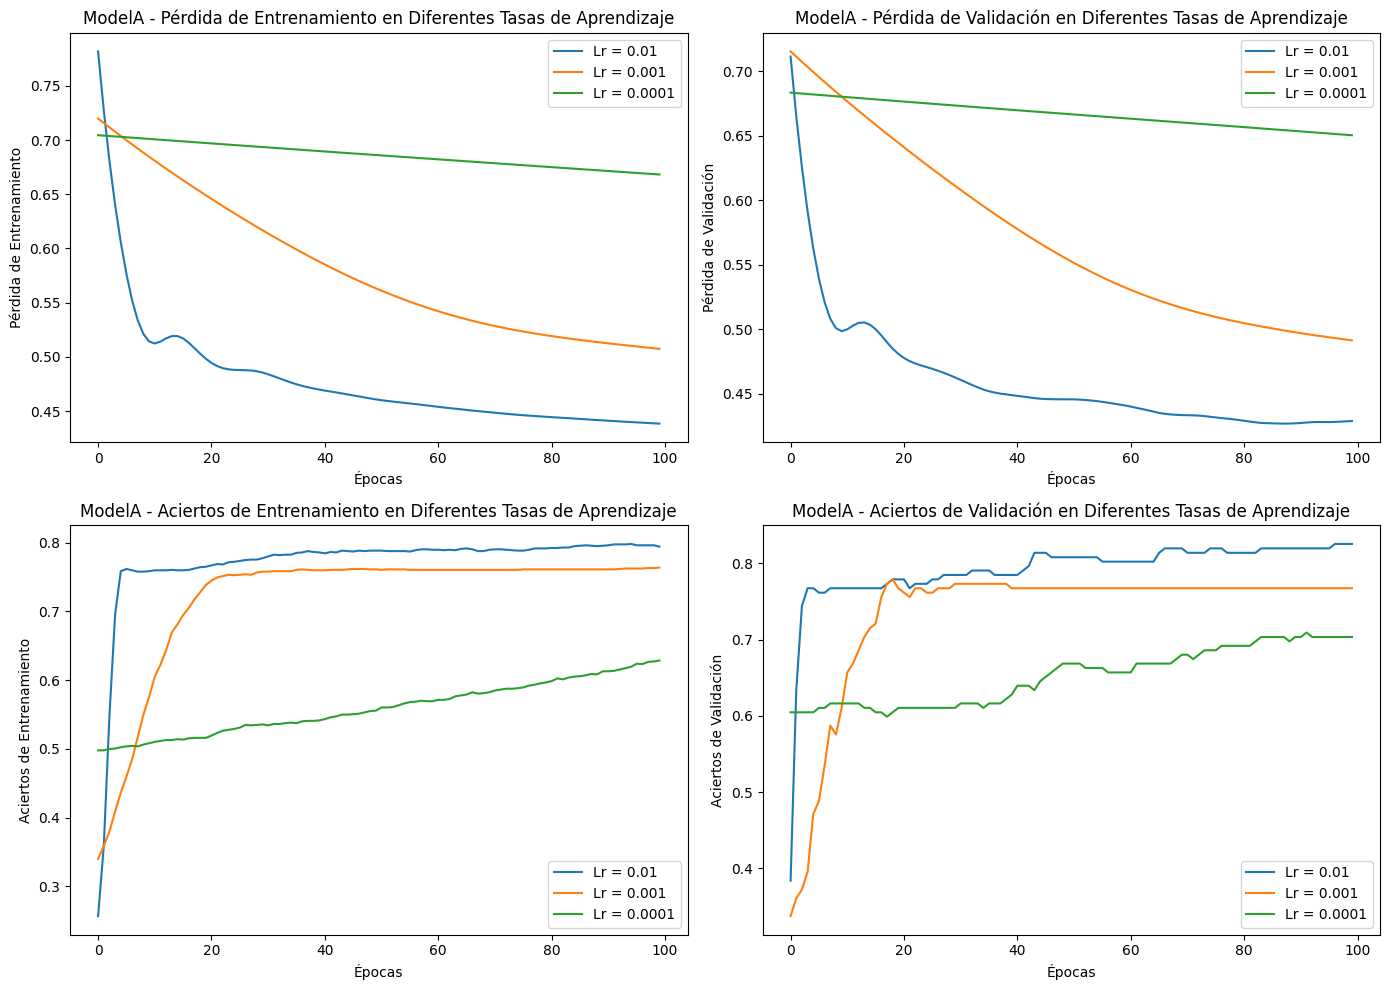

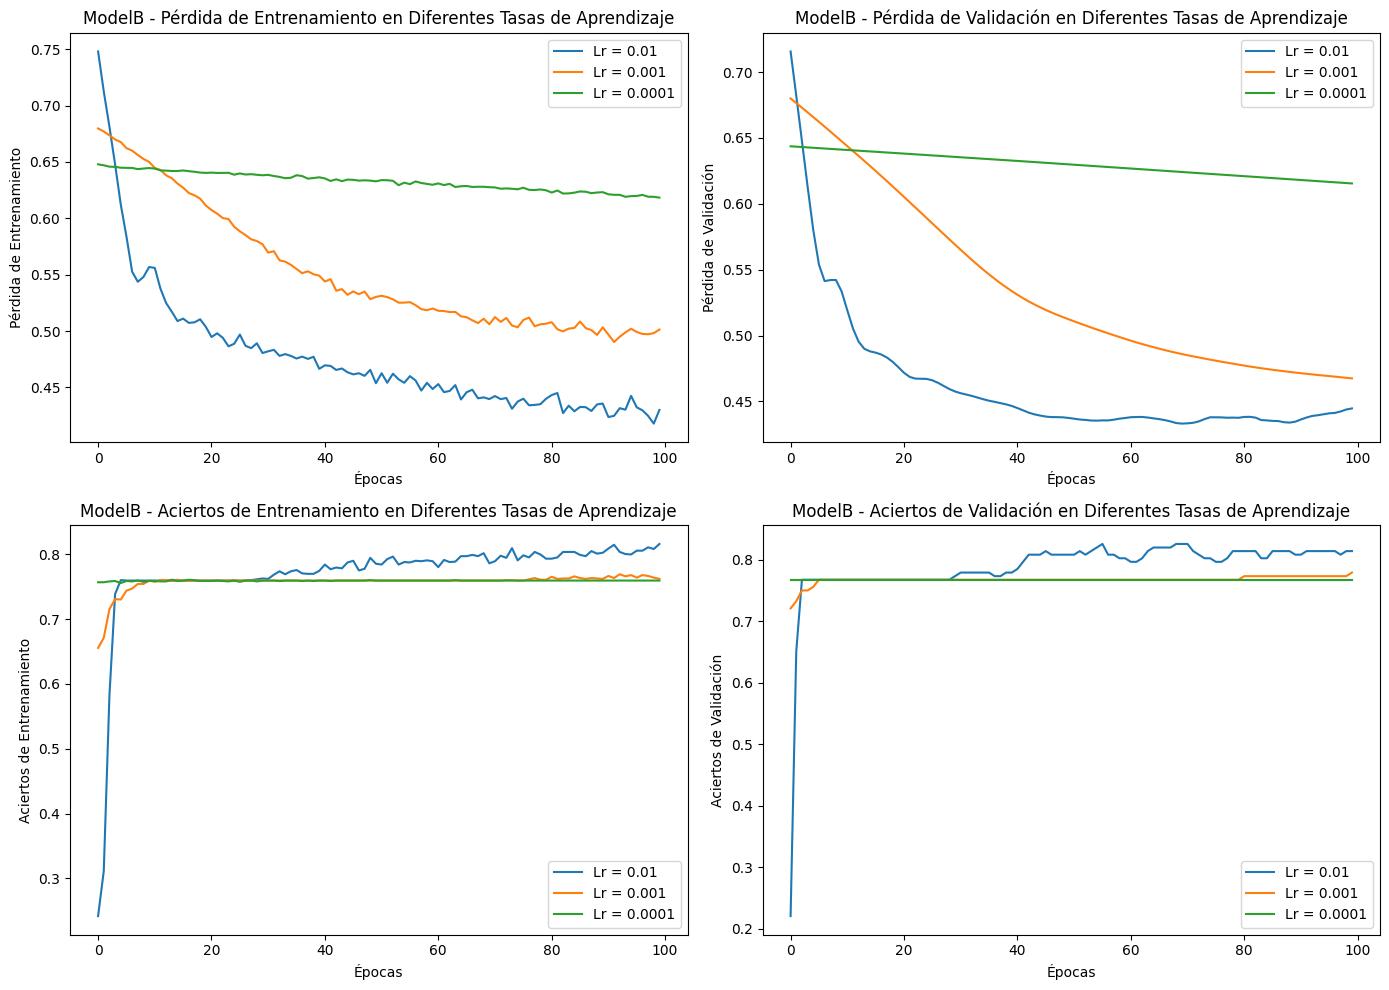

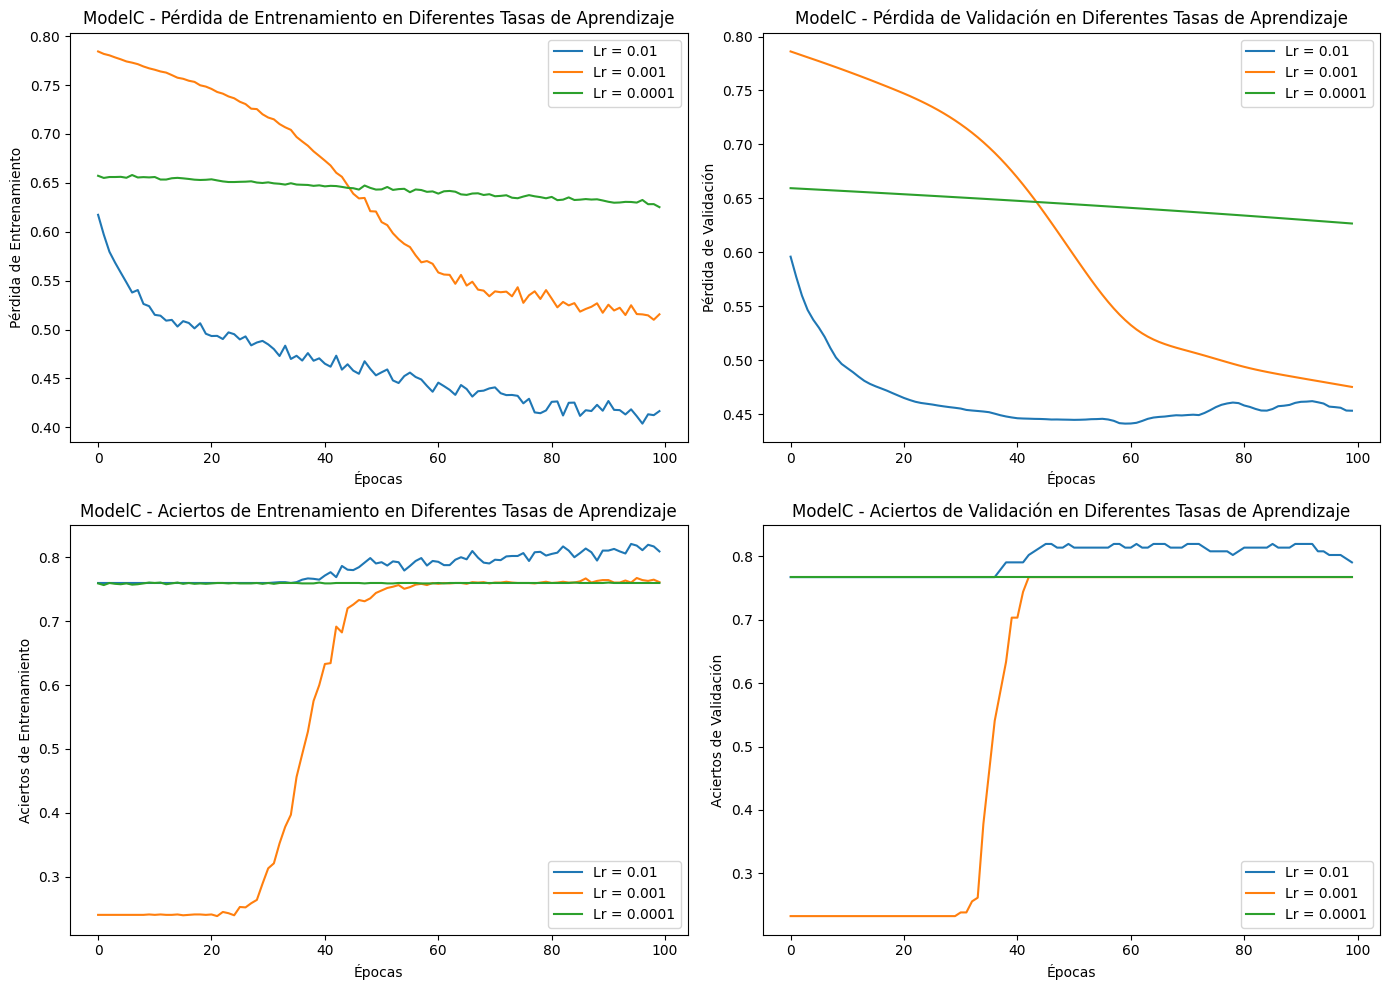

In [93]:
def plot_model_metrics_across_learning_rates(results):
    # Extraer nombres únicos de los modelos
    model_names = ['ModelA', 'ModelB', 'ModelC']
    
    # Graficar para cada modelo
    for model_name in model_names:
        # Inicializar listas para almacenar datos para cada tasa de aprendizaje
        epochs_list = None
        all_train_loss, all_val_loss = {}, {}
        all_train_accuracy, all_val_accuracy = {}, {}
        
        # Recopilar datos para todas las tasas de aprendizaje para el modelo actual
        for (name, lr), metrics in results.items():
            if name == model_name:
                # Inicializar la lista de épocas solo una vez
                if epochs_list is None:
                    epochs_list = range(0, len(metrics["train_loss"]))
                
                all_train_loss[lr] = metrics["train_loss"]
                all_val_loss[lr] = metrics["val_loss"]
                all_train_accuracy[lr] = metrics["train_accuracy"]
                all_val_accuracy[lr] = metrics["val_accuracy"]

        # Graficar pérdida de entrenamiento y validación para todas las tasas de aprendizaje
        plt.figure(figsize=(14, 10))
        
        # Pérdida de Entrenamiento
        plt.subplot(2, 2, 1)
        for lr, train_loss in all_train_loss.items():
            plt.plot(epochs_list, train_loss, label=f'Lr = {lr}')
        plt.xlabel('Épocas')
        plt.ylabel('Pérdida de Entrenamiento')
        plt.title(f'{model_name} - Pérdida de Entrenamiento en Diferentes Tasas de Aprendizaje')
        plt.legend()
        
        # Pérdida de Validación
        plt.subplot(2, 2, 2)
        for lr, val_loss in all_val_loss.items():
            plt.plot(epochs_list, val_loss, label=f'Lr = {lr}')
        plt.xlabel('Épocas')
        plt.ylabel('Pérdida de Validación')
        plt.title(f'{model_name} - Pérdida de Validación en Diferentes Tasas de Aprendizaje')
        plt.legend()

        # Aciertos de Entrenamiento
        plt.subplot(2, 2, 3)
        for lr, train_accuracy in all_train_accuracy.items():
            plt.plot(epochs_list, train_accuracy, label=f'Lr = {lr}')
        plt.xlabel('Épocas')
        plt.ylabel('Aciertos de Entrenamiento')
        plt.title(f'{model_name} - Aciertos de Entrenamiento en Diferentes Tasas de Aprendizaje')
        plt.legend()
        
        # Aciertos de Validación
        plt.subplot(2, 2, 4)
        for lr, val_accuracy in all_val_accuracy.items():
            plt.plot(epochs_list, val_accuracy, label=f'Lr = {lr}')
        plt.xlabel('Épocas')
        plt.ylabel('Aciertos de Validación')
        plt.title(f'{model_name} - Aciertos de Validación en Diferentes Tasas de Aprendizaje')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

plot_model_metrics_across_learning_rates(results)


En general, los gráficos muestran que una tasa de aprendizaje de 0.01 logra el mejor equilibrio en los tres modelos (ModelA, ModelB y ModelC), alcanzando una pérdida baja rápidamente y una tasa de aciertos alta tanto en entrenamiento como en validación. Esto sugiere una buena convergencia sin problemas significativos de sobreajuste.

Con una tasa de aprendizaje de 0.001, el aprendizaje es más lento, pero también estable, alcanzando un buen rendimiento aunque con una tasa de aciertos ligeramente menor al final.

Por otro lado, con una tasa de 0.0001, el aprendizaje es excesivamente lento y no permite que los modelos alcancen un rendimiento satisfactorio en las épocas disponibles, mostrando pérdidas y aciertos notablemente inferiores en comparación con las tasas mayores.

Además, es notable que, aunque ModelC es más complejo (con capas adicionales, dropout y diferente función de activación que el resto), no presenta una ventaja clara sobre ModelA en cuanto a los aciertos finales. Esta situación era esperable, considerando observaciones previas que indicaron que el modelo 4 era suficientemente complejo para el problema. Aún así, a partir de nuestras observaciones y resultados, se refuerza la idea de que modelos más simples son adecuados para este conjunto de datos, y que la complejidad adicional de ModelC no contribuye a una mejora significativa en el rendimiento, al menos con las tasas de aprendizaje y configuraciones actuales empleadas.

In [94]:
records = [{"Model": model, "Learning Rate": lr, "F1 Score": metrics["f1_score"]} 
           for (model, lr), metrics in results.items()]

results_df = pd.DataFrame(records)

# Encontrar el modelo con el mejor F1 Score
best_model = results_df.loc[results_df["F1 Score"].idxmax()]
html = results_df.to_html(index=False)

print("Tabla de Mejores Resultados:")
display(HTML(html))

print("\nMejor Modelo:")
print(best_model)

Tabla de Mejores Resultados:


Model,Learning Rate,F1 Score
ModelA,0.0100,0.802653
ModelA,0.0010,0.666463
ModelA,0.0001,0.707143
ModelB,0.0100,0.785824
ModelB,0.0010,0.693025
ModelB,0.0001,0.666463
ModelC,0.0100,0.776780
ModelC,0.0010,0.666463
ModelC,0.0001,0.666463



Mejor Modelo:
Model              ModelA
Learning Rate        0.01
F1 Score         0.802653
Name: 0, dtype: object


**Obs:** No obtuvimos un modelo que fuera mejor que el resto consistentemente. Por esto, optamos por elegir el ModelA como nuestro Modelo 5, ya que es el más simple y, a pesar de esto, logra un rendimiento similar a los otros modelos más complejos. 

## **3. Evaluación**

In [95]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1

A continuación, entrenamos los modelos del 1 al 5 sobre el conjunto completo de entrenamiento, y validamos sobre el conjunto de prueba.

In [102]:
model1Final, _ = train_logistic_regression(X_final_train, y_final_train, X_test, y_test)

model2Final = SimpleLinearNN(input_size=input_size)
X_final_train_tensor = torch.FloatTensor(X_final_train.values)
y_final_train_tensor = torch.LongTensor(y_final_train.values)
X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.LongTensor(y_test.values)
_ = train_model(model2Final, X_final_train_tensor, y_final_train_tensor, X_test_tensor, y_test_tensor, epochs, learning_rate, criterion='CrossEntropyLoss',modelNumber=2)

model3Final = SigmoidNN(input_size=input_size)
X_final_train_tensor = torch.FloatTensor(X_final_train.values)
y_final_train_tensor = torch.FloatTensor(y_final_train.values).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1)
_ = train_model(model3Final, X_final_train_tensor, y_final_train_tensor, X_test_tensor, y_test_tensor, epochs, learning_rate, criterion='BCELoss', modelNumber=3)

model4Final = FeedForwardNN(input_size=input_size)
_ = train_model(model4Final, X_final_train_tensor, y_final_train_tensor, X_test_tensor, y_test_tensor, epochs, learning_rate, criterion='BCELoss', modelNumber=4)

# Mejor modelo de los 3 que propusimos
model5Final = ModelA(input_size=input_size)
_ = train_model(model5Final, X_final_train_tensor, y_final_train_tensor, X_test_tensor, y_test_tensor, epochs, learning_rate, criterion='BCELoss', modelNumber=5)


In [103]:
results_list = []
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5']
models = [model1Final, model2Final, model3Final, model4Final, model5Final]
for model, name in zip(models, model_names):
    if name == 'Model 1':
        accuracy, precision, recall, f1 = evaluate_model(model, X_test, y_test)
    else:
        X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
        accuracy, precision, recall, f1 = evaluate_model(model, X_test_tensor, y_test)
    
    results_list.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

results_df = pd.DataFrame(results_list)
html = results_df.to_html(index=False)

display(HTML(html))

Model,Accuracy,Precision,Recall,F1
Model 1,0.780374,0.765767,0.780374,0.742522
Model 2,0.789720,0.785927,0.789720,0.749975
Model 3,0.782710,0.790744,0.782710,0.730413
Model 4,0.775701,0.768897,0.775701,0.725084
Model 5,0.773364,0.751458,0.773364,0.743566


Con estos resultados finales, podemos observar resultados similares en todos los modelos, notando que los modelos 1 y 2 presentan consistentemente un rendimiento ligeramente superior que el 3 y 4, con el Modelo 5 (ModelA) llegando a un rendimiento similar a los mejores.

### **Comparativa con laboratorios anteriores**

En el análisis de los resultados, podemos observar que los modelos basados en redes neuronales así como el de regresión logística, muestran un desempeño inferior al compararlos con los algoritmos tradicionales de aprendizaje supervisado, como Naive Bayes e ID3, implementados en laboratorios previos. Los modelos neuronales presentan métricas de precisión, exactitud y F1 score más bajas, lo que sugiere que no están capturando de manera óptima las relaciones presentes en el conjunto de datos en comparación con Naive Bayes e ID3. Sin embargo, para los modelos anteriores se incluyó la columna time, cuyo valor tiene gran correlación con la columna objetivo. Esto sugiere que el rendimiento superior de Naive Bayes e ID3 puede estar influenciado por esta variable, que facilita la clasificación al aportar una relación directa con la clase.

| Algoritmo | Accuracy | Precision | Recall  | F1       |
|-----------|----------|-----------|---------|----------|
|Naive Bayes| 0.862150 | 0.857795  | 0.862150| 0.858234 |
|ID3        | 0.796729 | 0.809427  | 0.796729| 0.801747 |

## **Bibliografía**
- 3Blue1Brown. (2017a, October 5). *But what is a neural network? | Chapter 1*, Deep learning [Video]. YouTube. https://www.youtube.com/watch?v=aircAruvnKk 
- 3Blue1Brown. (2017b, October 16). *Gradient descent, how neural networks learn | Chapter 2*, Deep learning [Video]. YouTube. https://www.youtube.com/watch?v=IHZwWFHWa-w 
- 3Blue1Brown. (2017c, November 3). *What is backpropagation really doing? | Chapter 3*, Deep learning [Video]. YouTube. https://www.youtube.com/watch?v=Ilg3gGewQ5U
- aprendaut | FING. (n.d.). https://eva.fing.edu.uy/mod/folder/view.php?id=106324 
- Brownlee, J. (2019, August 6). *A Gentle Introduction to Dropout for Regularizing Deep Neural Networks.* Machine Learning Mastery. Retrieved October 29, 2024, from https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/
- Godoy, D. (2022, July 10). *Understanding binary cross-entropy / log loss: a visual explanation.* Medium. https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a 
- Ibm. (2024, October 25). *Neural network*. IBM. https://www.ibm.com/topics/neural-networks 
- Krishnamurthy, B. (2024, February 26). *An introduction to the RELU activation function.* Built In. https://builtin.com/machine-learning/relu-activation-function#:~:text=The%20ReLU%20activation%20function%20is%20used%20to%20introduce%20nonlinearity%20in,function%20outputs%20the%20same%20value. 
- PyTorch documentation — *PyTorch 2.5 documentation.* (n.d.). https://pytorch.org/docs/stable/index.html 
- scikit-learn: machine learning in Python — *scikit-learn 1.5.2 documentation.* (n.d.). https://scikit-learn.org/stable/ 
- Wikipedia contributors. (2024a, August 29). *Dilution (neural networks).* Wikipedia. https://en.wikipedia.org/wiki/Dilution_(neural_networks) 
- Wikipedia contributors. (2024b, October 17). *Feedforward neural network.* Wikipedia. https://en.wikipedia.org/wiki/Feedforward_neural_network 
- Wikipedia contributors. (2024c, October 19). *Vanishing gradient problem.* Wikipedia. https://en.wikipedia.org/wiki/Vanishing_gradient_problem 
- Wikipedia contributors. (2024d, October 21). *Rectifier (neural networks).* Wikipedia. https://en.wikipedia.org/wiki/Rectifier_(neural_networks) 
- Wikipedia contributors. (2024e, October 22). *Sigmoid function.* Wikipedia. https://en.wikipedia.org/wiki/Sigmoid_function 
- Wikipedia contributors. (2024f, October 23). *Hyperbolic functions.* Wikipedia. https://en.wikipedia.org/wiki/Hyperbolic_functions
